In [138]:
import numpy as np
import pandas as pd
pd.options.display.max_columns = 100

idx = pd.IndexSlice

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb

import json

In [2]:
with open('../2021 election/cob_precincts.json','r') as f:
    cob_precincts = json.load(f)

In [157]:
sov_df = pd.read_csv('../Data/Elections/all-election-cleaned-sov.csv')

# Clean up
sov_df.replace({'Contest Name':{'City Of Boulder Council Candidates':'City of Boulder Council Candidates'}},inplace=True)
sov_df.replace({'Party':{'DEM':'Democratic','REP':'Republican','LBR':'Libertarian','GRN':'Green'}},inplace=True)

c_2016_dem = sov_df['Choice Name'] == 'Hillary Clinton / Tim Kaine'
c_2016_rep = sov_df['Choice Name'] == 'Donald J. Trump / Michael R. Pence'
sov_df.loc[c_2016_dem,'Party'] = sov_df.loc[c_2016_dem,'Choice Name'].map({'Hillary Clinton / Tim Kaine':'Democratic'})
sov_df.loc[c_2016_rep,'Party'] = sov_df.loc[c_2016_rep,'Choice Name'].map({'Donald J. Trump / Michael R. Pence':'Republican'})

sov_df.head()

C:\Users\Brian\AppData\Local\Temp\ipykernel_28876\2887528879.py:1: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  sov_df = pd.read_csv('../Data/Elections/all-election-cleaned-sov.csv')


,Year,Active Voters,Total Ballots,Contest Name,Choice Name,Total Votes,Party,Precinct Name
0,2012,1369,1032,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2163307100
1,2012,1369,1040,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2163307101
2,2012,1787,857,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2163307102
3,2012,1186,954,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,1,American,2163307103
4,2012,1197,953,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2163307104


In [158]:
c = sov_df['Precinct Name'].isin(cob_precincts)
cob_sov_df = sov_df.loc[c,:]

In [159]:
incomplete_contests = {}

for year in range(2012,2022):
    pivot_df = pd.pivot_table(
        data = cob_sov_df[cob_sov_df['Year'] == year],
        index = 'Precinct Name',
        columns = ['Contest Name'],
        values = 'Total Votes',
        aggfunc = np.nansum
    )

    pivot_filter_df = pivot_df.isnull().sum().sort_values()
    incomplete_contests[year] = list(pivot_filter_df[pivot_filter_df > 2].index)

incomplete_contest_l = set([j for i in incomplete_contests.values() for j in i])

cob_complete_sov_df = cob_sov_df[~cob_sov_df['Contest Name'].isin(incomplete_contest_l)]

In [160]:
cob_sov_pos_l = []
for _year in cob_sov_df['Year'].unique():
    _position_mapping = dict(enumerate(cob_complete_sov_df.loc[cob_complete_sov_df['Year'] == _year,'Contest Name'].unique()))
    _position_mapping = {v:k+1 for k,v in _position_mapping.items()}
    _df = cob_complete_sov_df.copy().loc[cob_complete_sov_df['Year'] == _year]
    _df['Position'] = _df['Contest Name'].map(_position_mapping)
    cob_sov_pos_l.append(_df)
    
cob_sov_pos_df = pd.concat(cob_sov_pos_l)

cob_sov_pos_df.head()

,Year,Active Voters,Total Ballots,Contest Name,Choice Name,Total Votes,Party,Precinct Name,Position
125,2012,972,781,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2181007800,1
126,2012,588,472,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2181007801,1
127,2012,1052,640,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2181007802,1
129,2012,1434,1175,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,2,American,2181007804,1
131,2012,1272,933,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,1,American,2181007806,1


In [197]:
multichoice_contests = cob_sov_pos_df.groupby(['Year','Contest Name']).agg({'Choice Name':'nunique'})['Choice Name']
multichoice_contests = (multichoice_contests < 2).reset_index()
multichoice_contests.rename(columns={'Choice Name':'Multichoice'},inplace=True)
multichoice_contests.head()

,Year,Contest Name,Multichoice
0,2012,Amendment 64 (Constitutional),False
1,2012,Amendment 65 (Constitutional),False
2,2012,Amendment S (Constitutional),False
3,2012,City Of Boulder Ballot Issue No. 2A,False
4,2012,City Of Boulder Ballot Issue No. 2B,False


In [170]:
contest_party_pivot_df = pd.pivot_table(
    data = cob_sov_pos_df,
    index = ['Year','Contest Name'],
    columns = 'Party',
    values = 'Total Votes',
    aggfunc = 'sum'
)

dem_voteshare = contest_party_pivot_df.loc[:,'Democratic'] / contest_party_pivot_df.sum(1)
dem_voteshare.describe()

count    46.000000
mean      0.876770
std       0.084993
min       0.749542
25%       0.808237
50%       0.850037
75%       0.999567
max       1.000000
dtype: float64

In [ ]:
contest_party_pivot_df = pd.pivot_table(
    data = cob_sov_pos_df,
    index = ['Year','Contest Name'],
    columns = 'Party',
    values = 'Total Votes',
    aggfunc = 'sum'
)

dem_voteshare = contest_party_pivot_df.loc[:,'Democratic'] / contest_party_pivot_df.sum(1)
dem_voteshare.describe()

In [108]:
agg_d = {'Total Votes':'sum','Active Voters':'max','Total Ballots':'max','Position':'max'}
cob_precinct_turnout = cob_sov_pos_df.groupby(['Year','Precinct Name','Contest Name']).agg(agg_d)
cob_precinct_turnout.reset_index(inplace=True)

# City council races 
c0 = cob_precinct_turnout['Contest Name'] == 'City of Boulder Council Candidates'
cob_precinct_turnout.loc[c0,'Total Votes'] = cob_precinct_turnout.loc[c0,'Total Votes'] / 5

# Calculate turnout
cob_precinct_turnout['Turnout'] = cob_precinct_turnout['Total Votes'] / cob_precinct_turnout['Active Voters']

# Odd/even
cob_precinct_turnout['Odd'] = (cob_precinct_turnout['Year'] % 2).astype(bool)

cob_precinct_turnout.head()

,Year,Precinct Name,Contest Name,Total Votes,Active Voters,Total Ballots,Position,Turnout,Odd
0,2012,2181007800,Amendment 64 (Constitutional),757.0,972,781,20,0.778807,False
1,2012,2181007800,Amendment 65 (Constitutional),725.0,972,781,21,0.745885,False
2,2012,2181007800,Amendment S (Constitutional),679.0,972,781,19,0.698560,False
3,2012,2181007800,County Commissioner - District 1,605.0,972,781,7,0.622428,False
4,2012,2181007800,County Commissioner - District 2,692.0,972,781,8,0.711934,False


In [ ]:
federal_state_contests = [
    'Presidential Electors',
    'United States Senator',
    'United States Congress',
    'Governor/Lieutenant Governor',
    'Secretary Of State',
    'State Treasurer',
    'Attorney General',
    'State Board of Education',
    'Regent of the University of Colorado',
]

cob_sov_pos_df[cob_sov_pos_df['Contest Name'].isin()]

In [43]:
_df1 = cob_sov_pos_df.groupby('Year').agg({'Contest Name':'nunique'})
_df2 = cob_sov_pos_df.groupby(['Year','Contest Name','Choice Name']).agg({'Total Ballots':'sum','Active Voters':'sum'}).groupby(level=[0]).max()

election_stats = pd.concat([_df1,_df2],axis=1)
election_stats['Turnout'] = election_stats['Total Ballots'] / election_stats['Active Voters']

election_stats['Odd'] = election_stats.index % 2
election_stats['Odd'] = election_stats['Odd'].apply(bool)

election_stats

,Contest Name,Total Ballots,Active Voters,Turnout,Odd
Year,,,,,
2012,25,66921,100991,0.662643,False
2013,12,35096,74623,0.470311,True
2014,38,49874,68812,0.724786,False
2015,14,31442,67188,0.467970,True
2016,40,68926,77394,0.890586,False
2017,13,33652,77304,0.435320,True
2018,47,61273,74212,0.825648,False
2019,11,37247,73349,0.507805,True
2020,34,67338,75007,0.897756,False


In [59]:
unique_contests = cob_sov_pos_df['Contest Name'].str.split(' - ').str.get(0).str.strip().unique()
exclude_criteria = ['amendment','ballot issue','ballot question','proposition','county','regional','district','council candidates']

surviving_contests = {}
for c in unique_contests:
    surviving_contests[c] = {}
    for e in exclude_criteria:
        if e in c.lower():
            surviving_contests[c][e] = 1
        else:
            surviving_contests[c][e] = 0

surviving_s = pd.DataFrame(surviving_contests).sum()
surviving_s[surviving_s == 0]

Presidential Electors                                  0
Representative To The 113Th United States Congress     0
State Board Of Education                               0
Regent Of The University Of Colorado                   0
State Senate                                           0
Justice Of The Colorado Supreme Court                  0
Court Of Appeals                                       0
United States Senator                                  0
Representative To The 114th  United States Congress    0
Governor/Lieutenant Governor                           0
Secretary Of State                                     0
State Treasurer                                        0
Attorney General                                       0
Representative to the 115th United States Congress     0
Regent of the University of Colorado                   0
State Senator                                          0
Colorado Supreme Court Justice                         0
Colorado Court of Appeals Judge

### Visualizing

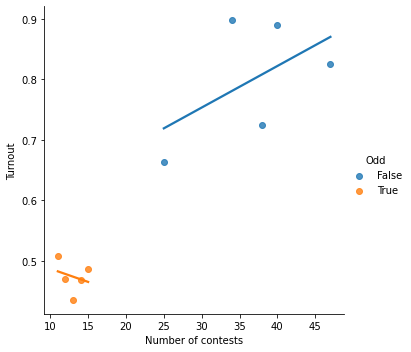

In [44]:
sb.lmplot(
    data = election_stats,
    x = 'Contest Name',
    y = 'Turnout',
    hue = 'Odd',
    ci = 0
#     line_kws = {'color':'r','alpha':.5}
)

plt.xlabel('Number of contests')

plt.savefig('turnout_by_contest_number.png',facecolor='white')

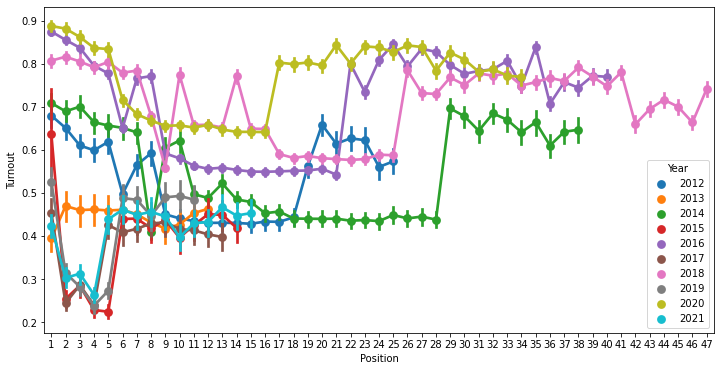

In [87]:
f,ax = plt.subplots(figsize=(12,6))
sb.pointplot(
    data = cob_precinct_turnout,
    x = 'Position',
    y = 'Turnout',
    hue = 'Year',
    ax = ax
)

plt.savefig('turnout_by_position.png',facecolor='white')

In [181]:
cob_precinct_turnout.loc[cob_precinct_turnout['Odd'],['Position','Turnout']].corr().iloc[0,1]

0.20280444445125825

In [182]:
cob_precinct_turnout.loc[~cob_precinct_turnout['Odd'],['Position','Turnout']].corr().iloc[0,1]

0.12990567391127728

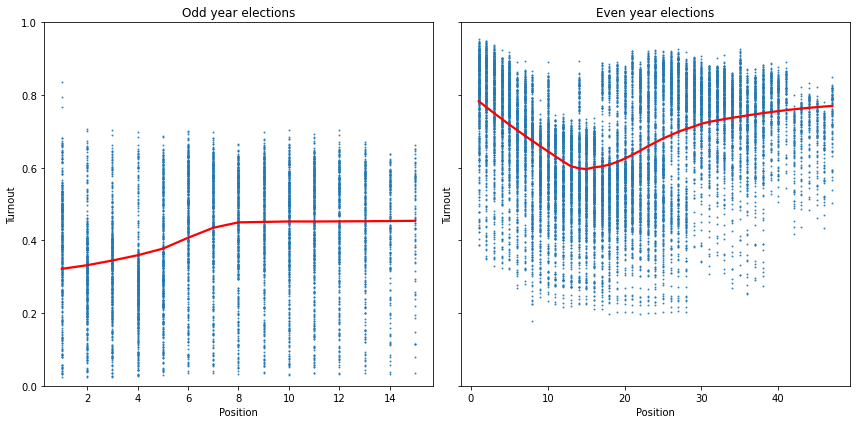

In [188]:
f,axs = plt.subplots(1,2,figsize=(12,6),subplot_kw={'ylim':(0,1)},sharey=True)

sb.regplot(
    data = cob_precinct_turnout[cob_precinct_turnout['Odd']],
    x = 'Position',
    y = 'Turnout',
    ax = axs[0],
    scatter_kws = {'s':1},
    line_kws = {'color':'red'},
    lowess = True
)

sb.regplot(
    data = cob_precinct_turnout[~cob_precinct_turnout['Odd']],
    x = 'Position',
    y = 'Turnout',
    ax = axs[1],
    scatter_kws = {'s':1},
    line_kws = {'color':'red'},
    lowess = True
)

axs[0].set_title('Odd year elections')
axs[1].set_title('Even year elections')

f.tight_layout()
f.savefig('turnout_by_position_odd_even.png',facecolor='white')

## Predictability

In [253]:
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor, GradientBoostingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.svm import LinearSVR
from sklearn.metrics import get_scorer_names

from sklearn.model_selection import cross_val_score

In [237]:
precinct_contest_winner_d = {}

for year in range(2012,2022):
    _pivot = pd.pivot_table(
        data = cob_sov_pos_df[cob_sov_pos_df['Year'] == year],
        index = ['Precinct Name'],
        columns = ['Contest Name','Choice Name'],
        values = 'Total Votes'
    )

    _ix = cob_sov_pos_df[cob_sov_pos_df['Year'] == year].groupby(['Contest Name','Choice Name']).agg({'Total Votes':'sum'}).groupby(level=[0]).idxmax()['Total Votes']

    _df = _pivot / _pivot.sum(axis=1,level=0)
    precinct_contest_winner_d[year] = _df.loc[:,_ix].fillna(0)

C:\Users\Brian\AppData\Local\Temp\ipykernel_28876\400362339.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  _df = _pivot / _pivot.sum(axis=1,level=0)
C:\Users\Brian\AppData\Local\Temp\ipykernel_28876\400362339.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  _df = _pivot / _pivot.sum(axis=1,level=0)
C:\Users\Brian\AppData\Local\Temp\ipykernel_28876\400362339.py:13: FutureWarning: Using the level keyword in DataFrame and Series aggregations is deprecated and will be removed in a future version. Use groupby instead. df.sum(level=1) should use df.groupby(level=1).sum().
  _df = _pivot / _pivot.sum(axis=1,level=0)
C:\Users\Brian\AppData\Local\Temp\ipykernel_28876

In [271]:
rf = RandomForestRegressor(n_jobs=-1)
ab = AdaBoostRegressor()
gb = GradientBoostingRegressor(n_jobs=-1)
lr = LinearRegression(n_jobs=-1)

scores_d = {}

for year,_df in precinct_contest_winner_d.items():
    scores_d[year] = {}
    
    _columns = _df.columns
    for col in _columns:
        scores_d[year][col] = {}
        
        _X_cols = list(set(_columns) - set(col))
    
        for _estimator in [rf,ab,gb,lr]:
            
            _name = _estimator.__class__.__name__
            
            scores_d[year][col][_name] = cross_val_score(
                estimator = _estimator,
                X = _df.loc[:,_X_cols],
                y = _df.loc[:,col],
                scoring = 'r2',
                cv=5).mean()

In [319]:
scores_df = pd.DataFrame.from_dict(scores_d,orient='index').stack([0,1]).apply(pd.Series)
scores_df.index = scores_df.index.droplevel(2)
scores_df.drop(columns=['LinearRegression'],inplace=True)
scores_df = pd.DataFrame(scores_df.stack())
scores_df['Position'] = cob_sov_pos_df.groupby(['Year','Contest Name']).agg({'Position':'max'})
scores_df.reset_index(inplace=True)
scores_df.columns = ['Year','Contest Name','Estimator','Score','Position']
scores_df['Odd'] = (scores_df['Year'] % 2).apply(bool)
scores_df

,Year,Contest Name,Estimator,Score,Position,Odd
0,2012,Amendment 64 (Constitutional),RandomForestRegressor,0.982210,20,False
1,2012,Amendment 64 (Constitutional),AdaBoostRegressor,0.979800,20,False
2,2012,Amendment 64 (Constitutional),GradientBoostingRegressor,0.988744,20,False
3,2012,Amendment 65 (Constitutional),RandomForestRegressor,0.976159,21,False
4,2012,Amendment 65 (Constitutional),AdaBoostRegressor,0.978690,21,False
...,...,...,...,...,...,...
742,2021,Proposition 119 (Statutory),AdaBoostRegressor,0.877406,6,True
743,2021,Proposition 119 (Statutory),GradientBoostingRegressor,0.914438,6,True
744,2021,Proposition 120 (Statutory),RandomForestRegressor,0.909666,7,True
745,2021,Proposition 120 (Statutory),AdaBoostRegressor,0.895194,7,True


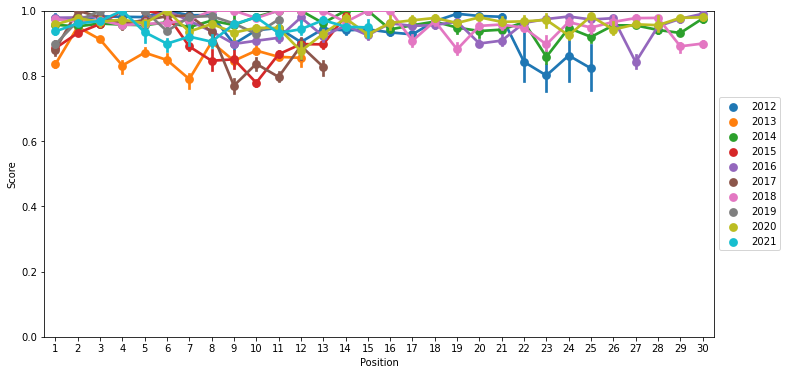

In [315]:
f,ax = plt.subplots(figsize=(12,6))
sb.pointplot(
    data = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)],
    x = 'Position',
    y = 'Score',
    hue = 'Year',
    ax = ax
)

ax.set_ylim((0,1))
ax.legend(loc='center left',bbox_to_anchor=(1,.5))

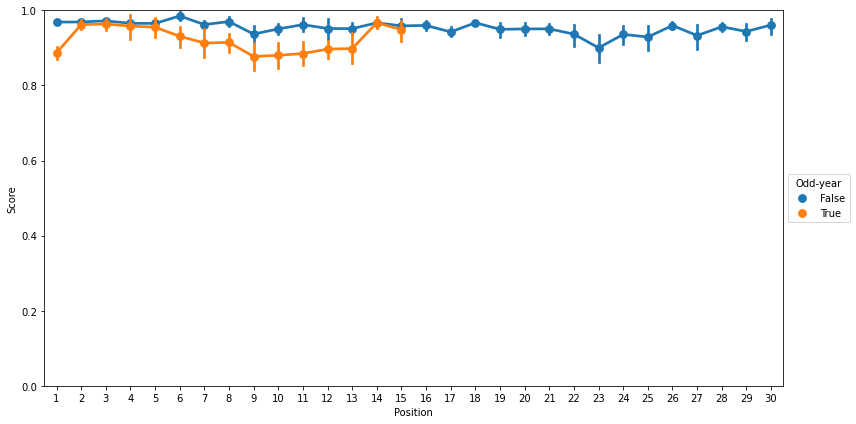

In [322]:
f,ax = plt.subplots(figsize=(12,6))
sb.pointplot(
    data = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)],
    x = 'Position',
    y = 'Score',
    hue = 'Odd',
    ax = ax
)

ax.set_ylim((0,1))
ax.legend(loc='center left',bbox_to_anchor=(1,.5),title='Odd-year')

f.tight_layout()
f.savefig('predictability_position.png',facecolor='white',bbox_inches='tight')

<AxesSubplot:xlabel='Position', ylabel='Score'>

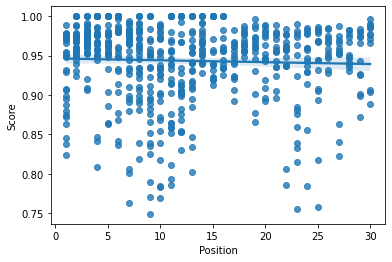

In [312]:
sb.regplot(
    data = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)],
    x = 'Position',
    y = 'Score',
)

In [318]:
_df = scores_df[(scores_df['Score'] > 0) & (scores_df['Position'] < 31)]
_df[['Score','Position']].corr().iloc[0,1]

-0.03911028724739549

## Bikerack

In [74]:
cob_sov_pos_df.loc[(cob_sov_pos_df['Year'] == 2012) & (cob_sov_pos_df['Contest Name'] == 'Presidential Electors') & (cob_sov_pos_df['Precinct Name'] == '2181007800')]

,Year,Active Voters,Total Ballots,Contest Name,Choice Name,Total Votes,Party,Precinct Name,Position
125,2012,972,781,Presidential Electors,Virgil H. Goode Jr. / Jim Clymer,0,American,2181007800,1
357,2012,972,781,Presidential Electors,Barack Obama / Joe Biden,480,Democratic,2181007800,1
589,2012,972,781,Presidential Electors,Mitt Romney / Paul Ryan,287,Republican,2181007800,1
821,2012,972,781,Presidential Electors,Gary Johnson / James P. Gray,10,Libertarian,2181007800,1
1053,2012,972,781,Presidential Electors,Jill Stein / Cheri Honkala,1,Green,2181007800,1
1285,2012,972,781,Presidential Electors,Stewart Alexander / Alex Mendoza,0,"Socialist, USA",2181007800,1
1517,2012,972,781,Presidential Electors,"Ross C. ""Rocky"" Anderson / Luis J. Rodriguez",0,Justice,2181007800,1
1749,2012,972,781,Presidential Electors,Roseanne Barr / Cindy Lee Sheehan,0,Peace and Freedom,2181007800,1
1981,2012,972,781,Presidential Electors,James Harris / Alyson Kennedy,0,Socialist Workers,2181007800,1
2213,2012,972,781,Presidential Electors,Tom Hoefling / Jonathan D. Ellis,0,America's,2181007800,1


In [81]:
cob_sov_pos_df.loc[(cob_sov_pos_df['Year'] == 2012) & (cob_sov_pos_df['Precinct Name'] == '2181007800')].groupby('Contest Name').agg({'Total Votes':'sum'})

,Total Votes
Contest Name,
Amendment 64 (Constitutional),757
Amendment 65 (Constitutional),725
Amendment S (Constitutional),679
County Commissioner - District 1,605
County Commissioner - District 2,692
County Judge - Boulder - John F. Stavely,539
Court Of Appeals - Daniel Marc Taubman,533
Court Of Appeals - Dennis A. Graham,534
Court Of Appeals - Gale T. Miller,533


In [76]:
cob_sov_pos_df.groupby(['Year','Contest Name','Precinct Name']).agg({'Total Votes':'sum'}).loc[(2012,'Presidential Electors')]

,Total Votes
Precinct Name,
2181007800,778
2181007801,469
2181007802,638
2181007804,1168
2181007806,928
...,...
2181307885,594
2181307886,751
2181307887,936


In [39]:
c0 = cob_precinct_turnout['Year'] == 2015
c1 = cob_precinct_turnout['Position'] == 1
c2 = cob_precinct_turnout['Turnout'] > 1
cob_precinct_turnout.loc[c0 & c1 & c2].sort_values('Turnout')

,Year,Position,Precinct Name,Active Voters,Total Ballots,Turnout
6599,2015,1,2181007822,255,291,1.141176
6589,2015,1,2181007812,255,306,1.200000
6588,2015,1,2181007811,255,378,1.482353
6597,2015,1,2181007820,255,428,1.678431
6593,2015,1,2181007816,255,447,1.752941
6598,2015,1,2181007821,255,462,1.811765
6596,2015,1,2181007819,255,485,1.901961
6594,2015,1,2181007817,255,507,1.988235
6583,2015,1,2181007806,255,510,2.000000
6587,2015,1,2181007810,255,520,2.039216


In [35]:
c0 = cob_sov_pos_df['Year'] == 2015
c1 = cob_sov_pos_df['Position'] == 1
c2 = cob_sov_pos_df['Precinct Name'] == '2181007808'
cob_sov_pos_df.loc[c0 & c1 & c2]


,Year,Active Voters,Total Ballots,Contest Name,Choice Name,Total Votes,Party,Precinct Name,Position
41967,2015,255,770,City of Boulder Council Candidates,Jared Kaszuba,34,NaN,2181007808,1
41968,2015,255,770,City of Boulder Council Candidates,Lisa Morzel,340,NaN,2181007808,1
41969,2015,255,770,City of Boulder Council Candidates,Leonard May,177,NaN,2181007808,1
41970,2015,255,770,City of Boulder Council Candidates,Edward Jabari,45,NaN,2181007808,1
41971,2015,255,770,City of Boulder Council Candidates,Cha Cha Spinrad,76,NaN,2181007808,1
41972,2015,255,770,City of Boulder Council Candidates,Bob Yates,301,NaN,2181007808,1
41973,2015,255,770,City of Boulder Council Candidates,Aaron Brockett,333,NaN,2181007808,1
41974,2015,255,770,City of Boulder Council Candidates,Julianne McCabe,69,NaN,2181007808,1
41975,2015,255,770,City of Boulder Council Candidates,Bill Rigler,199,NaN,2181007808,1
41976,2015,255,770,City of Boulder Council Candidates,Tim Plass,226,NaN,2181007808,1


In [27]:
c0 = cob_precinct_turnout['Year'] == 2019
c1 = cob_precinct_turnout['Position'] == 1
cob_precinct_turnout.loc[c0 & c1]

,Year,Position,Precinct Name,Active Voters,Total Ballots,Turnout
16585,2019,1,2181007800,428,266,0.621495
16586,2019,1,2181007801,622,289,0.464630
16587,2019,1,2181007802,463,182,0.393089
16588,2019,1,2181007804,366,221,0.603825
16589,2019,1,2181007806,1230,680,0.552846
...,...,...,...,...,...,...
16668,2019,1,2181307885,589,382,0.648557
16669,2019,1,2181307886,804,513,0.638060
16670,2019,1,2181307887,959,625,0.651721
16671,2019,1,2181307888,832,576,0.692308


In [29]:
154/255

0.6039215686274509